# Notebook configuration

In [1]:
run_number    = 4446
save_plots    = False
plots_format  = "pdf"
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "run{}_corrections.h5".format(run_number)
#copy_corr_to  = "/Users/Gonzalo/github/NEXTdata/XYmaps/"
inputfilename = "/home/brais/Documents/Next/Kr/data/{0}/dst_{0}.root.h5".format(run_number)

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 15e3
Erange_zcorr  =   5e3, 15e3
Erange_xycorr =   9e3, 14e3
Erange_fit    = 11500, 13500
Qrange        =     0, 10e2
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-3, 1.2e-2

S1Erange      =     0, 40
S1Wrange      =     0, 400
S1Hrange      =     0, 10
S2Wrange      =     0, 50
S2Hrange      =     0, 10e3
NSirange      =     0, 30

Zrange_DV     =   545, 555
Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan

extra_pitches = [( 25,  25),
                 ( 50,  50),
                 ( 75,  75),
                 (100, 100)]

split_sample  = True

In [2]:
Emin_fit      = Erange_fit[0]
Emax_fit      = Erange_fit[1]
Emean_fit     = 0.5*sum(Erange_fit)

# Kr analysis

In [3]:
import os
import shutil
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
from   copy              import copy


import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string


xy_map = dstf.load_xy_corrections("/home/brais/Documents/Next/Correction_maps/run4628_corrections.h5")

pi   = np.pi
save = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None

Running on  Mon Sep 25 14:21:21 2017


#### General plotting options

In [4]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [6]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full#[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

62364


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,3,1.498855e+09,0,1,225.0,8.846622,52.280453,103125.0,13.354375,1026.412231,...,653837.5,6,550.7125,550.7125,-63.594418,-16.808640,65.778267,-2.883192,6.368430,6.604301
1,4,1.498855e+09,0,1,350.0,2.025267,15.240196,219275.0,12.262375,1504.927368,...,654112.5,9,434.8375,434.8375,92.378665,-49.306269,104.713542,-0.490275,7.859703,7.077931
2,5,1.498855e+09,0,1,150.0,1.761057,8.805047,507025.0,6.912687,2882.450928,...,652912.5,9,145.8875,145.8875,132.661609,-98.440055,165.195481,-0.638386,6.515345,7.052158
3,6,1.498855e+09,0,2,325.0,5.813896,30.049382,132700.0,11.003438,1026.416138,...,654262.5,6,521.5625,521.5625,99.314243,-40.558958,107.276968,-0.387718,4.970292,8.730874
4,6,1.498855e+09,1,2,325.0,5.813896,30.049382,132700.0,15.598875,1655.153320,...,681962.5,14,549.2625,549.2625,132.305139,-95.098586,162.936769,-0.623221,9.104363,9.883217


In [7]:
print("full dst: ",len(np.unique(full.event)))
print("nS2 = 2 : ",len((full[full.nS2==2])))
print("nS2 = 2 : ",len(np.unique(full[full.nS2==2].event)))
print("nS2 = 2 : ",len(full[full.nS2==2])/2.)
print("full dst: ",len(full[(full.nS2==2)&(full.peak==1)]))
print("full dst: ",len(full[(full.nS2==2)&(full.peak==0)]))
print("full dst: ",len(full.event))
print("full dst: ",len(np.unique(full.event)))

full dst:  56351
nS2 = 2 :  9146
nS2 = 2 :  4573
nS2 = 2 :  4573.0
full dst:  4573
full dst:  4573
full dst:  62364
full dst:  56351


In [8]:
selns2 = [] #np.zeros_like(full.nS2==2)
i = 0

#sel = full[np.fromiter(map(lambda evt: len(full[full.event==evt])==2, np.unique(full.event)),dtype=np.int,count=1000)]
evts = np.unique(full.event[full.nS2==2])
j = 0
for evt in evts:
    if j%5000==0: print(j)
    if len(full[full.event==evt])==2:
        selns2.append(full[full.event==evt])
        
    j += 1
    
    



#sl = np.fromiter(sel,dtype=np.int)

0


In [9]:
s2full = pd.concat(selns2)


In [10]:
print(len(s2full)/2.)

4573.0


In [11]:
three_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.gauss(x, *args[6:9]) + args[-1]


[  2.95976076e+04   8.31854437e+03   3.35555611e+02   5.24773098e+03
   9.52306345e+03   2.30526568e+02   4.47934793e+04   1.20000000e+04
   1.03403410e+03   5.03841310e-25]
[  1.21482652e+04   1.79542672e+01   6.48311870e+01   4.92897957e+03
   6.20454336e+01   1.09345979e+02   5.88079923e+04   5.97068003e+02
   7.73200847e+02   8.62179749e+00]


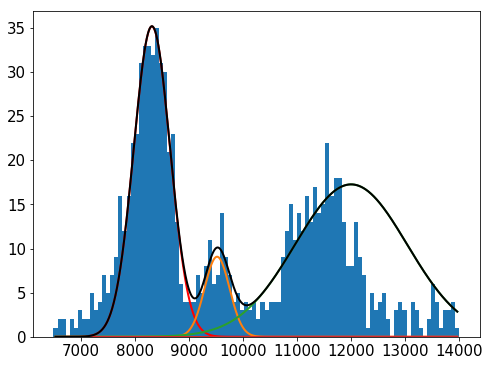

In [16]:
data = s2full
data = data[data.R<100]
#data = data[data.Z<100]

energy  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value
y, x, _ = hist(energy,100,[6.5e3,14e3]);

seed = 1e4,  8500, 300, 1e3, 10000, 500, 2.9e4, 12500,  500, 10
low  =  10,  8000,  50, 1e2,  9500,  50, 5.0e3, 12000,  100, 0 
upp  = 1e8,  10000, 900, 1e9, 11000, 500, 1e5, 13000, 9000, 100
f    = fitf.fit(three_gauss, x, y, seed, fit_range=(7.9e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:6]), linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[6:9]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)

#plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)


[ 17874.87214294  12675.73101743    284.4217414 ]
[ 287.84337087    5.28872142    5.28872151]


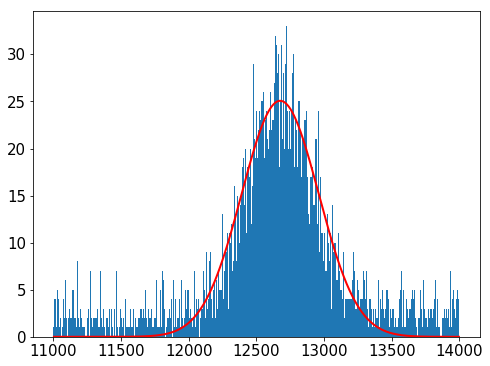

In [28]:
data = s2full
data = data[data.R<100]
#data = data[data.Z<100]

energy  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value
y, x, _ = hist(energy,500,[11e3,14e3]);

seed = 1e4,  12000, 500
low  =  10,  8000,  50  
upp  = 1e8,  9000, 900
f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=(7.9e3,14e3))
print(f.values)
print(f.errors)

xrange = np.linspace(x[0], x[-1],1000)
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)

[-169.32321988  309.33613872] [ 67.30489844   2.20122964]


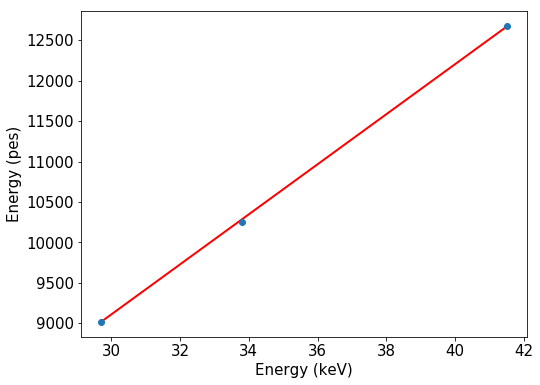

In [29]:
y  = np.array([9.01875451e+03,  1.02581892e+04 , 12675.73101743 ])
ey = np.array([1.25          ,  6.0            , 5.3 ])
x  = np.array([ 29.7         ,  33.8         , 41.5])

plt.errorbar(x, y, ey, fmt = 'o')
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (pes)")

f    = fitf.fit(fitf.polynom, x, y,  [0,0], fit_range=(28,45), sigma=ey)

xrange = np.linspace(x[0], x[-1],1000)
plt.plot(xrange, fitf.polynom(xrange, *f.values), "r-", linewidth=2)

print(f.values, f.errors)

trans = f.values

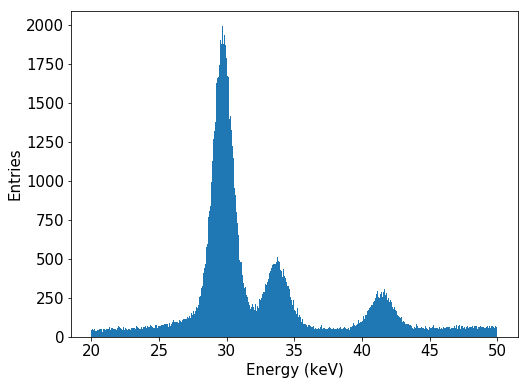

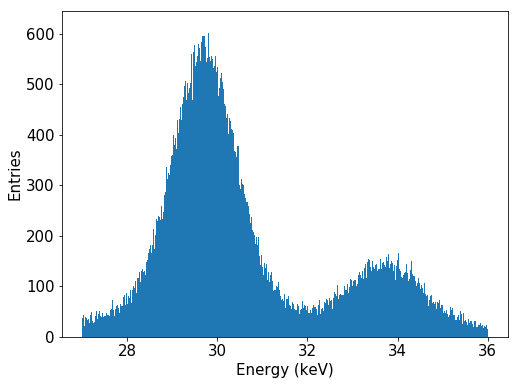

In [30]:
data = s2full
#data = data[data.R<100]
#data = data[data.Z<100]

energy  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value 
energy  = (energy-trans[0])/trans[1]
y, x, _ = hist(energy,500,[20,50])
plt.xlabel("Energy (keV)")
plt.ylabel("Entries")

y, x, _ = hist(energy,500,[27,36])
plt.xlabel("Energy (keV)")
plt.ylabel("Entries")

In [31]:
E1   = []
E2   = []
d    = []
auxE = [0,0]
j = 0
for evt in selns2:
    if j%5000==0: print(j)
    data = evt[evt.peak==0]
    aux  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value    
    d1 = np.array([np.array(data.X)[0], np.array(data.Y)[0],np.array(data.Z)[0]])
    auxE[0] = np.array((aux-trans[0])/trans[1] )[0]
    
    data = evt[evt.peak==1]
    aux  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value
    d2 = np.array([np.array(data.X)[0], np.array(data.Y)[0],np.array(data.Z)[0]])
    auxE[1] = np.array((aux-trans[0])/trans[1] )[0]
    
    d.append(np.sum((d1-d2)**2))
 
    
    E1.append(max(auxE))
    E2.append(min(auxE))
    
    j += 1


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000


In [32]:
d = np.array(d)**0.5
print(d)

[  24.6967801    18.80448331   88.76145876 ...,  249.02544861  102.40974931
   31.92428449]


In [33]:
import matplotlib.colors as colors

2025


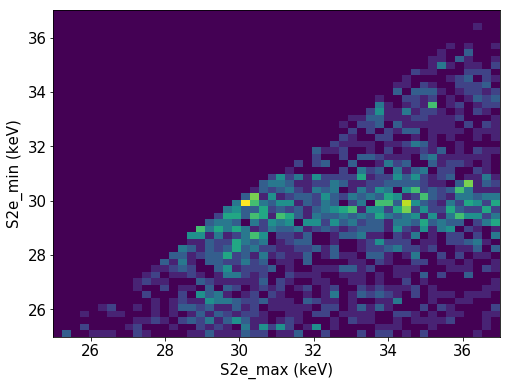

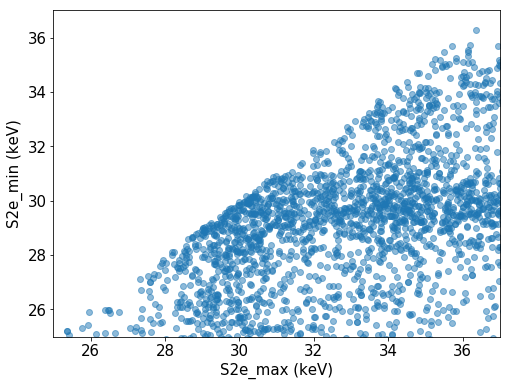

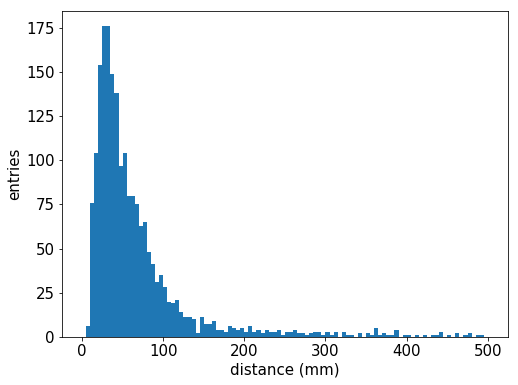

In [37]:
minE, maxE = 25,37

hist2d(np.array(E1),np.array(E2),[50,50],[[minE, maxE],[minE, maxE]])#, norm=colors.LogNorm());
plt.xlabel("S2e_max (keV)")
plt.ylabel("S2e_min (keV)")


plt.figure()
plt.plot(np.array(E1),np.array(E2), 'o',alpha=0.5)
plt.xlim(minE, maxE)
plt.ylim(minE, maxE)
plt.xlabel("S2e_max (keV)")
plt.ylabel("S2e_min (keV)")

selE = np.logical_and(coref.in_range(np.array(E1),minE, maxE), coref.in_range(np.array(E2),minE, maxE)) 

hist(d[selE],100,[0,500])
plt.xlabel("distance (mm)")
plt.ylabel("entries")

print(np.sum(np.logical_and(coref.in_range(np.array(E1),minE, maxE),coref.in_range(np.array(E2),minE, maxE))))